In [ ]:
from keras.datasets import imdb
from google.colab import drive
drive.mount('/content/drive')
prefix="drive/My Drive/MSc./Ensemble-Learning/Project/models/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.initializers import Constant
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import sequence

In [ ]:
max_len=10000
val_len=2500
maximum_sequence_length=500
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=max_len)
train_x=sequence.pad_sequences(train_x,maximum_sequence_length)
test_x=sequence.pad_sequences(test_x,maximum_sequence_length)
train_y=train_y.reshape(-1,1)

In [ ]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)
def vectorize(sequences, dimension = 10000):
 results = np.zeros((len(sequences), dimension))
 for i, sequence in enumerate(sequences):
  results[i, sequence] = 1
 return results
 
data = vectorize(data)
targets = np.array(targets).astype("float32")
test_x = data[:5000]
test_y = targets[:5000]
train_x = data[5000:]
train_y = targets[5000:]

In [ ]:
print('X_train: ' + str(train_x.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_x.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (45000, 5000)
Y_train: (45000,)
X_test:  (5000, 5000)
Y_test:  (5000,)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
 model = Sequential()
# Input - Layer
  model.add(Dense(256, activation = "selu", input_shape=(10000, )))
  # Hidden - Layers
  model.add(Dropout(0.2, noise_shape=None, seed=None))
  #model.add(Dense(256, activation = "selu"))
  #model.add(Dropout(0.2, noise_shape=None, seed=None))
  model.add(Dense(64, activation = "selu"))
  # Output- Layer
  model.add(Dense(1, activation = "sigmoid"))
  # compiling the model
  model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
  )

(60000, 28, 28, 1)

In [ ]:
from tensorflow.keras.layers import Dense,LSTM, Embedding,Dropout,Flatten,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Bidirectional
embedding_dim = 16


In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, batch, logs=None):
      global logEpochs
      logEpochs.append(self.weights_to_list(self.model.get_weights()))
    def on_epoch_end(self, epoch, logs={}):
      global logEpochs,weights
      logEpochs.append(self.weights_to_list(self.model.get_weights()))
      weights.append(self.model.get_weights())
    def weights_to_list(self,weights):
      l=[]
      for i in range(0,len(weights)):
          l+=weights[i].flatten().tolist()
      return l

def create_model(filters = 64, kernel_size = 7, strides=1, units = 10, 
                 optimizer='adam', rate = 0.2, kernel_initializer="glorot_uniform"):
  model = Sequential()
    # Embedding layer
  model.add(Embedding(max_len, embedding_dim, input_length= maximum_sequence_length))
  model.add(Conv1D(filters = filters, kernel_size = kernel_size,activation="relu"))
  model.add(MaxPooling1D(kernel_size-2))
  model.add(Conv1D(filters = filters, kernel_size = kernel_size,activation="relu"))
  model.add(MaxPooling1D(kernel_size-2))

  model.add(Conv1D(filters = filters, kernel_size = kernel_size,activation="relu"))
  #model.add(MaxPooling1D(kernel_size-2))

  model.add(GlobalMaxPooling1D())
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # Compile the model
  model.compile(loss='binary_crossentropy',
                optimizer= optimizer,
                metrics=['accuracy'])
  return model
def initModelWeights(model,c=0.3):
  weights=[]
  for w in model.get_weights():
    weights.append(np.random.normal(c, 0.001, size=w.shape))
  model.set_weights(weights)
#iki nokta arasındaki eğimi bulup bunu istenilen parçaya bölen kısım
def findSlope(w0,w1,bins):
  result=[]
  for i in range(len(w0)):
    w0i=w0[i]
    w1i=w1[i]
    result.append((w1i-w0i)/bins)
  return result
#eğim ve kaçıncı adım olduğu verildiğinde başlangıç noktasından bitiş noktasına belirtilen oranda ilerleten kısım
def nextStep(w0,slope,step):
  result=[]
  for i in range(len(w0)):
    w0i=w0[i]
    slopei=slope[i]
    result.append(w0i+(slopei*step))
  return result
#belli bir başlangıç noktasına göre modeli eğiten kısım
def runModel(startingPoint=0.2):
  global logEpochs, weights
  logEpochs=[]
  weights=[]
  model = create_model()
  initModelWeights(model,startingPoint)
  model.fit(train_x,train_y,epochs=16, batch_size=64,callbacks=[CustomCallback()])
  return logEpochs,weights
#Modelin hatasını hesaplayan kısım.
def evaluate(x,y,w0,w1,steps):
  bin_results=[]
  slope=findSlope(w0,w1,steps)
  for step in range(steps+1):
    w=nextStep(w0,slope,step)
    model.set_weights(w)
    bin_results.append(model.evaluate(x,y,batch_size=64))
  return bin_results
def evaluateWithPath(x,y,path):
  bin_results=[]
  for i in range(len(path)):
    model.set_weights(path[i])
    bin_results.append(model.evaluate(x,y,batch_size=64))
  return bin_results


In [ ]:
resultWeights=[]
resultEpochs=[]
startingPoints=[.02,0.05,0.1,0.15,0.2]

In [ ]:
model = create_model()
resultWeights=[]
resultEpochs=[]
startingPoints=[.02,0.05,0.1,0.15,0.2]
for i in range(len(startingPoints)):
  result=runModel(startingPoints[i])
  resultEpochs.append(result[0])
  resultWeights.append(result[1])


Epoch 1/16
391/391 [==============================] - 9s 5ms/step - loss: 0.7194 - accuracy: 0.5000
Epoch 2/16
391/391 [==============================] - 2s 4ms/step - loss: 0.6177 - accuracy: 0.6436
Epoch 3/16
391/391 [==============================] - 2s 4ms/step - loss: 0.4631 - accuracy: 0.8279
Epoch 4/16
391/391 [==============================] - 2s 4ms/step - loss: 0.3907 - accuracy: 0.8580
Epoch 5/16
391/391 [==============================] - 2s 4ms/step - loss: 0.3426 - accuracy: 0.8764
Epoch 6/16
391/391 [==============================] - 2s 4ms/step - loss: 0.3084 - accuracy: 0.8909
Epoch 7/16
391/391 [==============================] - 2s 4ms/step - loss: 0.2781 - accuracy: 0.9015
Epoch 8/16
391/391 [==============================] - 2s 4ms/step - loss: 0.2498 - accuracy: 0.9148
Epoch 9/16
391/391 [==============================] - 2s 5ms/step - loss: 0.2111 - accuracy: 0.9325
Epoch 10/16
391/391 [==============================] - 2s 5ms/step - loss: 0.1827 - accuracy: 0.9448

In [ ]:
def save_model_weights(model,prefix,label,points,weights):
  for i in range(len(points)):
    model.set_weights(weights[i][0])
    model.save_weights(prefix+"_"+label+str(points[i])+"_begin.h5")
    model.set_weights(weights[i][-1])
    model.save_weights(prefix+"_"+label+str(points[i])+"_end.h5")

In [ ]:
save_model_weights(model,prefix,"imdb",startingPoints,resultWeights)

In [ ]:
def load_model_weights(model,prefix,label,points):
  resultWeights=[]
  for i in range(len(points)):
    ws=[]
    model.load_weights(prefix+"_"+label+str(points[i])+"_begin.h5")
    ws.append(model.get_weights())
    model.load_weights(prefix+"_"+label+str(points[i])+"_end.h5")
    ws.append(model.get_weights())
    resultWeights.append(ws)
  return resultWeights
  

In [ ]:
resultWeights=load_model_weights(create_model(),prefix,"imdb",startingPoints)

In [ ]:
from numpy import linalg as LA
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
#Path bulmak için kullanılan sınıf
class PathFinderV2():
  prev_path=None
  next_path=None
  optimizers=None
  model=None
  loss_fn=None
  x=None
  y=None
  learning_rate=0.01
  def __init__(self,model,initial_path,loss_fn,x,y,learning_rate=0.001,optimizers=None):
    if model==None and initial_path==None:
      raise "Error"
    self.model=model
    self.optimizers=optimizers
    self.prev_path=initial_path
    self.loss_fn=loss_fn
    self.x=x
    self.y=y
    self.learning_rate=learning_rate
  def computeGradient(self):
    with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the
    # loss
      pred = self.model(self.x)
      loss = self.loss_fn(self.y.reshape(-1,1), pred)
    # calculate the gradients using our tape and then update the
    # model weights
    grads = tape.gradient(loss, self.model.trainable_variables)
    return grads

  def vec(self,begin,end):
    new_v=[]
    for i in range(len(begin)):
      new_v.append(begin[i]-end[i])
    return new_v

  def normalize(self,vector):
    flt_w=[]
    for a in vector:
      flt_w=flt_w+a.flatten().tolist()

    N=LA.norm(np.array(flt_w))
    new_vector=[]
    for w in vector:
      new_vector.append(w/N)
    return new_vector

  def computeTangent(self,i, l_next, l_prev, loss):
    new_dir=[]
    if l_next>l_prev:
      new_dir=self.vec(self.prev_path[i+1],self.prev_path[i])
    else:
      new_dir=self.vec(self.prev_path[i],self.prev_path[i-1])
    tangent=self.normalize(new_dir)
    return tangent

  def setWeights(self,weights):
    self.model.set_weights(weights)

  def computeLoss(self,q):
    self.model.set_weights(q)
    pred = self.model(self.x)
    loss = self.loss_fn(self.y.reshape(-1,1), pred)
    return loss

  def findNextIteration(self,):
    self.next_path=self.prev_path.copy()
    losses=[self.computeLoss(q)  for q in self.prev_path]
    #print("losses=",losses)
    for i in range(1,len(self.prev_path)-1):
      self.setWeights(self.prev_path[i])
      gradient=self.computeGradient()
      tangent=self.computeTangent(i,losses[i+1],losses[i-1],losses[i])
      self.next_path[i]=self.nebUpdate(self.prev_path[i],gradient,tangent,self.optimizers[i])
    self.prev_path=self.next_path
    self.next_path=None

  def nebUpdate(self,q,gradient,tangent,optimizer):
    new_q=[]
    grads=[]
    for i in range(len(gradient)):
      try:
        gradient[i].reshape(-1)
        
      except:
        gradient[i]=tf.convert_to_tensor(gradient[i])
      g=np.dot(gradient[i].reshape(-1), tangent[i].reshape(-1))*tangent[i]
      g=(gradient[i]-g)
      grads.append(g)
      #new_q.append(q[i]-self.learning_rate*(gradient[i]-g))
      self.model.set_weights(q)
    optimizer.apply_gradients(zip(grads, self.model.variables))    
    return self.model.get_weights()

  def findOptimalPath(self,iterate=100):
    print("iteration ",0, ", total_loss=",self.totalLoss())
    for i in range(iterate):
      self.findNextIteration()
      print("iteration ",i+1, ", total_loss=",self.totalLoss())

  def totalLoss(self):
    losses=[self.computeLoss(q) for q in self.prev_path]
    total=0
    for l in losses:
      total+=l
    return total
  
  def getPath(self,):
    return self.prev_path

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
#Lineer path ile optimum path i karçılaştıran sınıf
class ComparePaths():
  model=None
  initial_path=None
  optimized_path=None
  __initial_path_losses=[]
  __initial_path_accuracies=[]
  __optimized_path_losses=[]
  __optimized_path_accuracies=[]
  def __init__(self,model,initial_path,optimized_path):
    self.model=model
    self.initial_path=initial_path
    self.optimized_path=optimized_path

  def setOptimizedPath(self,optimized_path):
    self.optimized_path=optimized_path

  def plotResults(self,label_initial="",label_optimized=""):
    self.plotLossResults(label_initial,label_optimized)
    self.plotAccuracyResults(label_initial,label_optimized)

  def plotAccuracyResults(self,label_initial="",label_optimized="",figsize=(15,15)):
    plt.figure(figsize=figsize)
    plt.title("Accuracy Results")
    plt.plot(np.array(self.__initial_path_accuracies), label=label_initial)
    plt.plot(np.array(self.__optimized_path_accuracies), label=label_optimized)    
    plt.legend(loc='best')
    plt.show()

  def plotLossResults(self,label_initial="",label_optimized="",figsize=(15,15)):
    plt.figure(figsize=figsize)
    plt.title("Loss Results")
    plt.plot(np.array(self.__initial_path_losses), label=label_initial)
    plt.plot(np.array(self.__optimized_path_losses), label=label_optimized)    
    plt.legend(loc='best')
    plt.show()

  def plotPaths(self,label_initial='initial path',label_optimized='optimized path',figsize=(15,15)):
    path=self.__flatPath(self.optimized_path)
    ipath=self.__flatPath(self.initial_path)
    l=len(self.initial_path)
    pca=PCA(n_components=2)
    pca_allpath=pca.fit_transform(np.concatenate((ipath,path),axis=0))
    plt.figure(figsize=figsize)
    plt.plot(pca_allpath[:l,0], pca_allpath[:l,1], label=label_initial)
    plt.scatter([pca_allpath[:l,0]],[pca_allpath[:l,1]])
    plt.plot(pca_allpath[l:,0], pca_allpath[l:,1], label=label_optimized)
    plt.scatter([pca_allpath[l:,0]],[pca_allpath[l:,1]])
    plt.legend(loc='best')
    plt.show()
  
  def __flatPath(self,path):
    new_p=[]
    for i in range(len(path)):
      p=[]
      for j in range(len(path[i])):
        p=p+path[i][j].flatten().tolist()
      new_p.append(np.array(p))
    return np.array(new_p)

  def __evaluate(self,path,x,y):
    losses=[]
    accuracies=[]
    for i in range(len(path)):
      self.model.set_weights(path[i])
      result=self.model.evaluate(x,y,batch_size=64,verbose=0)
      losses.append(result[0])
      accuracies.append(result[1])
    return losses,accuracies

  def evaluateInitial(self,x,y):
    losses=[]
    accuracies=[]
    self.__initial_path_losses,self.__initial_path_accuracies=self.__evaluate(self.initial_path,x,y)
    return
    
  def evaluateOptimized(self,x,y):
    losses=[]
    accuracies=[]
    self.__optimized_path_losses,self.__optimized_path_accuracies=self.__evaluate(self.optimized_path,x,y)
    return
  

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
class Ensemble():
  models=[]
  loss_fn=None
  x=None
  y=None
  def __init__(self,models,loss_fn,x,y):
    if models==None or len(models)==0:
      raise "models can not be empty"
    if loss_fn==None:
      raise "Loss function cannot be None"
    self.models=models
    self.loss_fn=loss_fn
    self.x=x
    self.y=y
  def evaluate(self,x,y):
    preds=self.predictAll(x)
    loss=self.loss_fn(y,preds).numpy()
    acc=accuracy_score(y,np.where(preds > 0.5, 1, 0))
    return [loss,acc]

  def predictAll(self,x):
    preds=self.models[0](x)
    for i in range(1,len(self.models)):
      preds+=self.models[i](x)
    preds/=len(self.models)
    return preds
    
  def predict(self,x):
    preds=[]
    for i in range(len(self.models)):
      pred=self.models[i](x)
      preds.append(pred)
    counts = np.bincount(preds)
    return np.argmax(counts)
  
  def computeLoss(self,q):
    self.model.set_weights(q)
    pred = self.decision_making_fn(self.x)
    loss = self.loss_fn(self.y.reshape(-1,1), pred)
    return loss


In [ ]:
#Tüm işlemleri gerçekleştiren main class
class Runner():
  starting_points=[]#Başlangıç noktaları
  end_points={}#Optimum noktalar 
  from_to_optimized={} #Optimize edilmiş yolların birleşimi
  from_to_initial={} #lineer birleşim 
  all_in=None #Tüm noktaların birleşiminden ensemble
  end_ensembles=None
  ensembles={}
  train_x,train_y,test_x,test_y=None,None,None,None
  path_finders={}
  mapping=[]
  create_model_fn,loss_fn=None,None
  def __init__(self,create_model_fn,train_x,train_y,test_x,test_y,starting_points,end_points,loss_fn,mapping=[]):
    self.starting_points=starting_points
    self.end_points=end_points
    self.create_model_fn=create_model_fn
    self.mapping=mapping
    self.loss_fn=loss_fn
    self.train_x,self.train_y,self.test_x,self.test_y=train_x,train_y,test_x,test_y
    for i in range(len(mapping)):
      self.from_to_initial[mapping[i]]=[]
      self.from_to_optimized[mapping[i]]=[]
    
  def initPathFinders(self,bins=10,learning_rate=0.01):
    for i in range(len(self.mapping)):
      from_to=self.mapping[i]
      slope=findSlope(self.end_points[from_to[0]],self.end_points[from_to[1]],bins)
      initial_path=[nextStep(self.end_points[from_to[0]],slope,i) for i in range(bins+1)]
      self.from_to_initial[from_to]=initial_path
      self.from_to_optimized[from_to]=initial_path.copy()
      model=self.create_model_fn()
      self.path_finders[from_to]=PathFinderV2(model,initial_path,self.loss_fn,test_x,test_y,learning_rate=learning_rate,optimizers=[tf.optimizers.Adam() for j in range(bins)])

  def findOptimumPathForAll(self,iterate=100):
    for i in range(len(self.mapping)):
      from_to=self.mapping[i]
      path_finder=self.path_finders[from_to]
      path_finder.findOptimalPath(iterate=iterate)
      self.from_to_optimized[from_to]=path_finder.getPath()

  def compareAllPaths(self,):
    for i in range(len(self.mapping)):
      from_to=self.mapping[i]
      comparePath=ComparePaths(self.create_model_fn(),self.from_to_initial[from_to],self.from_to_optimized[from_to])
      comparePath.evaluateInitial(self.test_x,self.test_y)
      comparePath.evaluateOptimized(self.test_x,self.test_y)
      label_initial="initial path (from,to)="+str(from_to)
      label_optimized="optimized path (from,to)="+str(from_to)
      comparePath.plotPaths(label_initial,label_optimized)
      label_initial="initial loss (from,to)="+str(from_to)
      label_optimized="optimized loss (from,to)="+str(from_to)
      comparePath.plotLossResults(label_initial,label_optimized)
      label_initial="initial accuracy (from,to)="+str(from_to)
      label_optimized="optimized accuracy (from,to)="+str(from_to)
      comparePath.plotAccuracyResults(label_initial,label_optimized)

  def initEnsembleModels(self,):
    all=[]
    ends=[]
    for i in range(len(self.starting_points)):
      end=self.end_points[self.starting_points[i]]
      model=self.create_model_fn()
      model.set_weights(end)
      all.append(model)
    ends=all.copy()
    for i in range(len(self.mapping)):
      models=[]
      from_to=self.mapping[i]
      for j in range(len(self.from_to_optimized[from_to])):
        model=self.create_model_fn()
        model.set_weights(self.from_to_optimized[from_to][j])
        models.append(model)
        if j!=0 or j!=len(self.from_to_optimized[from_to])-1:
          all.append(model)
      e=Ensemble(models,self.loss_fn,self.test_x,self.test_y)
      self.ensembles[from_to]=e
    print(all)
    self.all_in=Ensemble(all,self.loss_fn,self.test_x,self.test_y)
    self.end_ensembles=Ensemble(ends,self.loss_fn,self.test_x,self.test_y)
  def evaluate(self,x=None,y=None):
    if x==None or y==None:
      x,y=self.test_x,self.test_y
    results={}
    for i in range(len(self.mapping)):
      from_to=self.mapping[i]
      e=self.ensembles[from_to]
      results[from_to]=e.evaluate(x,y)
    results["ends"]=self.end_ensembles.evaluate(x,y)
    results["all"]=self.all_in.evaluate(x,y)
    return results

  def getEnsembles(self,):
    all_ensembles=self.ensembles.copy()
    all_ensembles["ends"]=self.end_ensembles
    all_ensembles["all"]=self.all_in
    return all_ensembles

In [ ]:
end_points={}
loss_fn=tf.losses.BinaryCrossentropy()
mapping=[]
for i in range(len(startingPoints)-1):
  mapping.append((startingPoints[i],startingPoints[i+1]))
for i in range(len(startingPoints)-2):
  mapping.append((startingPoints[i],startingPoints[i+2]))
#for i in range(len(startingPoints)-3):
#  mapping.append((startingPoints[i],startingPoints[i+3]))
#for i in range(len(startingPoints)-4):
#  mapping.append((startingPoints[i],startingPoints[i+4]))
for i in range(len(startingPoints)):
  end_points[startingPoints[i]]=resultWeights[i][-1]

runner=Runner(create_model,train_x,train_y,test_x,test_y,startingPoints,end_points,loss_fn,mapping,)

In [ ]:
runner.initPathFinders(20,0.01)


In [ ]:
runner.initEnsembleModels()

[<keras.engine.sequential.Sequential object at 0x7fe51e2bf460>, <keras.engine.sequential.Sequential object at 0x7fe51bd8a0d0>, <keras.engine.sequential.Sequential object at 0x7fe51bc83220>, <keras.engine.sequential.Sequential object at 0x7fe51ede26d0>, <keras.engine.sequential.Sequential object at 0x7fe51dfdc790>, <keras.engine.sequential.Sequential object at 0x7fe51df67ac0>, <keras.engine.sequential.Sequential object at 0x7fe51e2e6b50>, <keras.engine.sequential.Sequential object at 0x7fe50c7eca00>, <keras.engine.sequential.Sequential object at 0x7fe51bf34850>, <keras.engine.sequential.Sequential object at 0x7fe51bcf0b80>, <keras.engine.sequential.Sequential object at 0x7fe3477d2c40>, <keras.engine.sequential.Sequential object at 0x7fe50c8785e0>, <keras.engine.sequential.Sequential object at 0x7fe530cb5c40>, <keras.engine.sequential.Sequential object at 0x7fe3478a25e0>, <keras.engine.sequential.Sequential object at 0x7fe51bb62c10>, <keras.engine.sequential.Sequential object at 0x7fe51e

In [ ]:
runner.evaluate()

{(0.02, 0.05): [1.3659594, 0.85428],
 (0.05, 0.1): [1.0311325, 0.83424],
 (0.1, 0.15): [0.829092, 0.80228],
 (0.15, 0.2): [0.750003, 0.71436],
 (0.02, 0.1): [1.1309118, 0.86544],
 (0.05, 0.15): [0.9204511, 0.83908],
 (0.1, 0.2): [0.8196503, 0.7814],
 'ends': [0.8108342, 0.76792],
 'all': [0.8701566, 0.84432]}

In [ ]:
runner.path_finders

{(-1, -0.35): <__main__.PathFinder at 0x7fbc86327a90>,
 (-0.35, 0.35): <__main__.PathFinder at 0x7fbc4a5c2af0>,
 (0.35, 1): <__main__.PathFinder at 0x7fbc86268b20>,
 (-1, 0.35): <__main__.PathFinder at 0x7fbc4a51f730>,
 (-0.35, 1): <__main__.PathFinder at 0x7fbc4b8e20a0>}

In [ ]:
runner.findOptimumPathForAll(50)

iteration  0 , total_loss= tf.Tensor(17.581926, shape=(), dtype=float32)
iteration  1 , total_loss= tf.Tensor(17.22568, shape=(), dtype=float32)
iteration  2 , total_loss= tf.Tensor(16.623838, shape=(), dtype=float32)
iteration  3 , total_loss= tf.Tensor(16.372753, shape=(), dtype=float32)
iteration  4 , total_loss= tf.Tensor(15.948437, shape=(), dtype=float32)
iteration  5 , total_loss= tf.Tensor(15.454123, shape=(), dtype=float32)
iteration  6 , total_loss= tf.Tensor(15.07714, shape=(), dtype=float32)
iteration  7 , total_loss= tf.Tensor(14.772244, shape=(), dtype=float32)
iteration  8 , total_loss= tf.Tensor(14.478556, shape=(), dtype=float32)
iteration  9 , total_loss= tf.Tensor(14.16467, shape=(), dtype=float32)
iteration  10 , total_loss= tf.Tensor(13.852608, shape=(), dtype=float32)
iteration  11 , total_loss= tf.Tensor(13.578304, shape=(), dtype=float32)
iteration  12 , total_loss= tf.Tensor(13.318415, shape=(), dtype=float32)
iteration  13 , total_loss= tf.Tensor(13.048268, sh

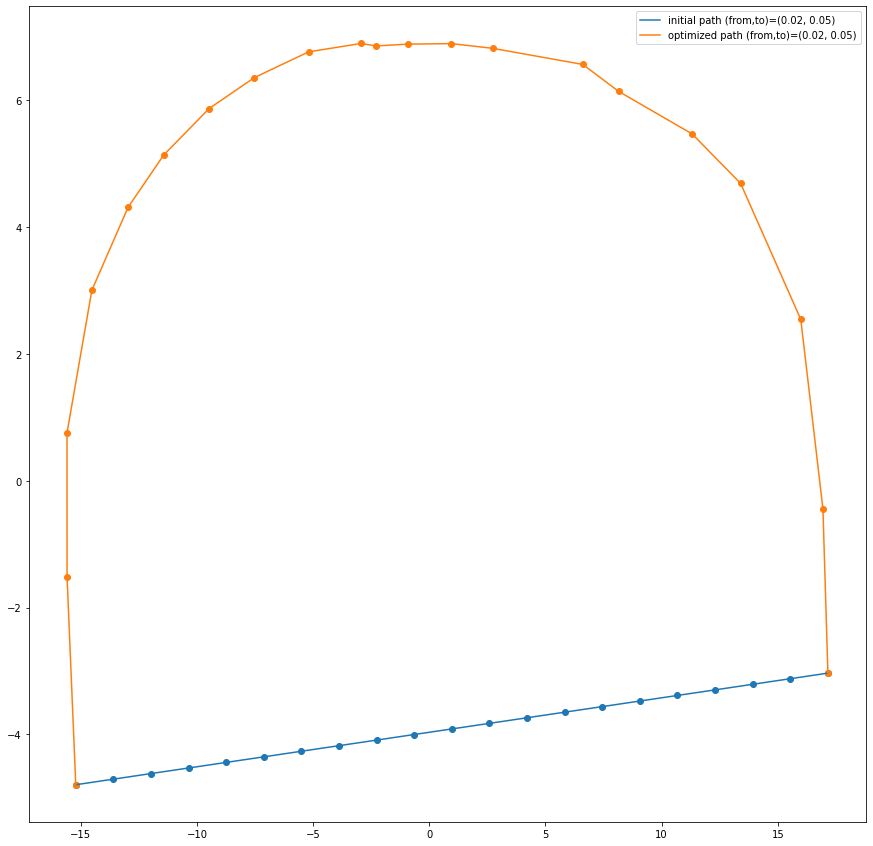

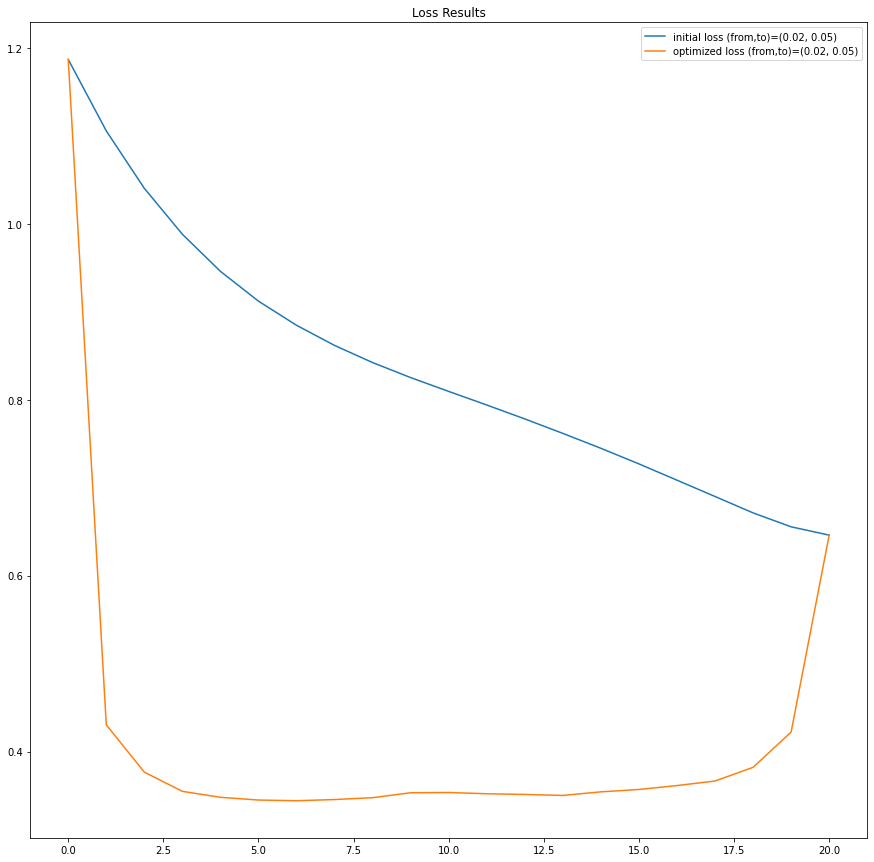

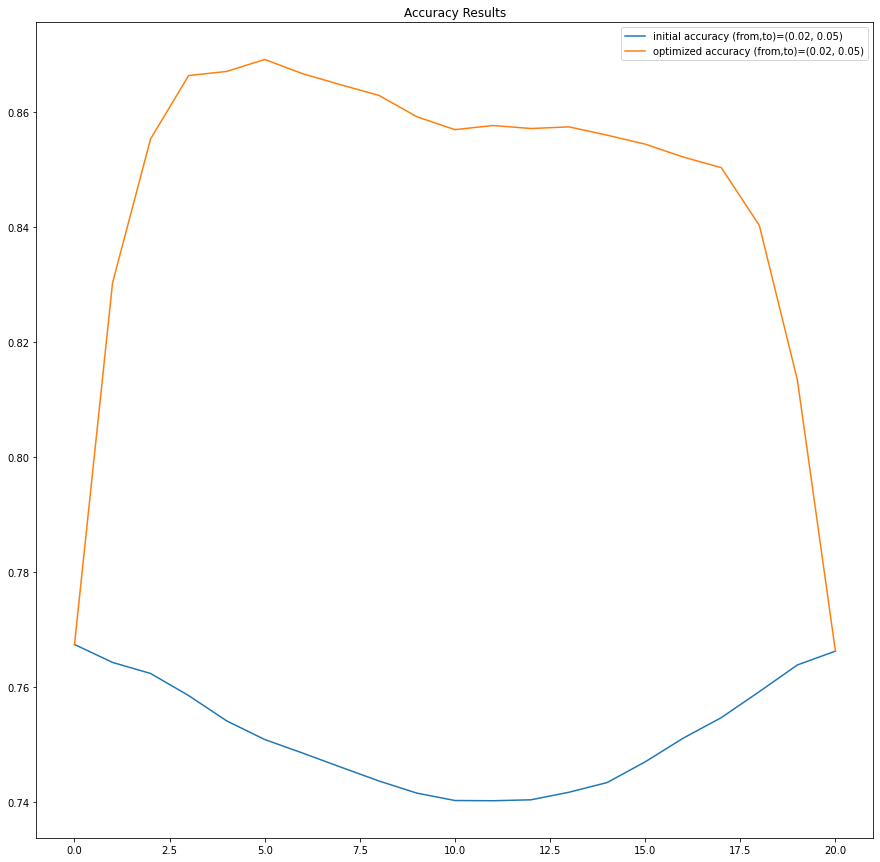

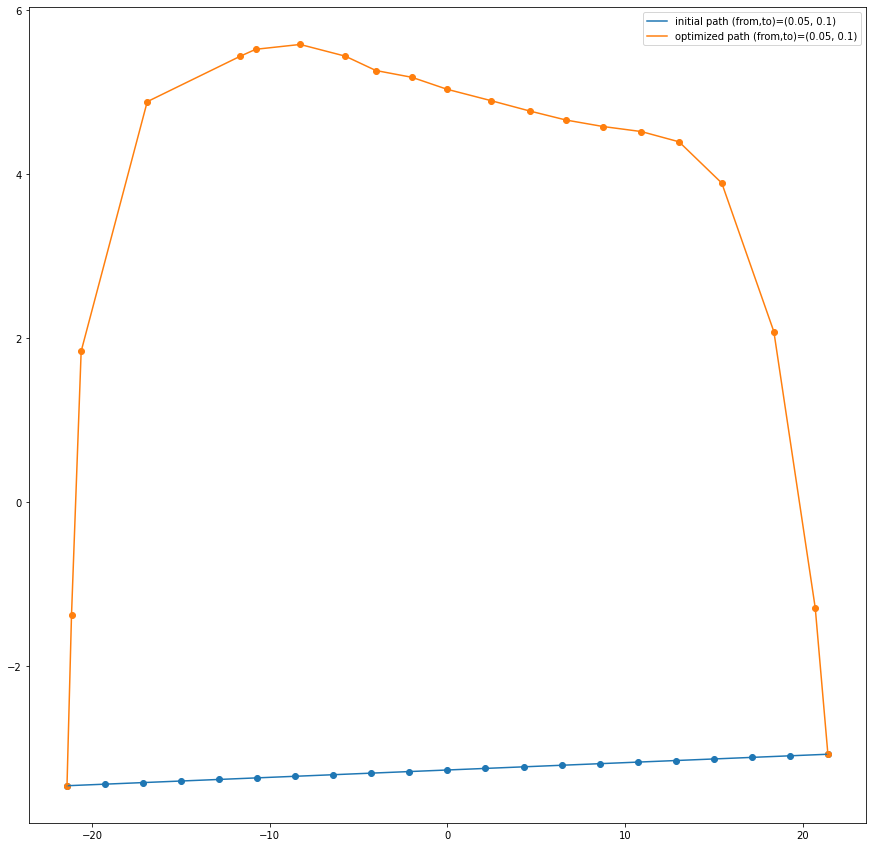

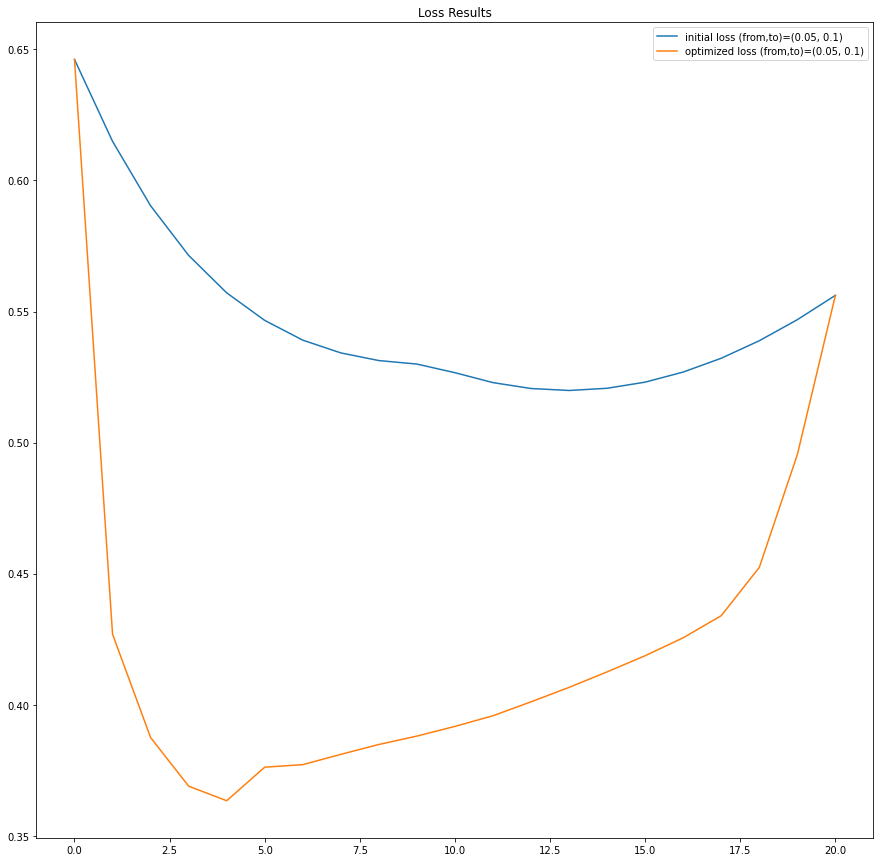

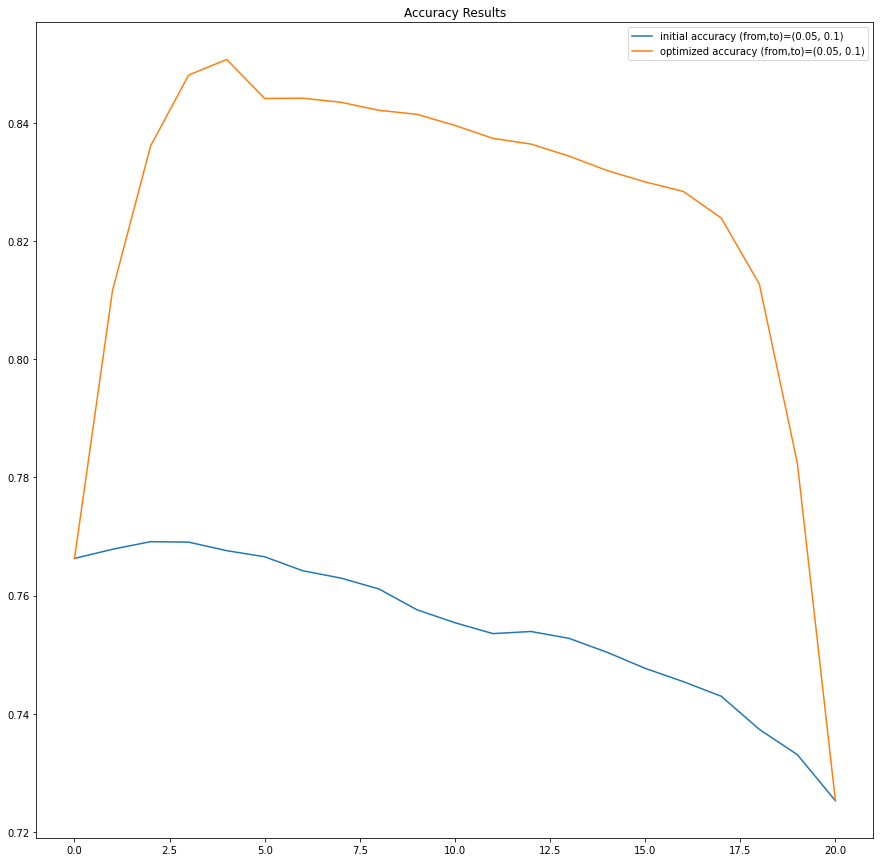

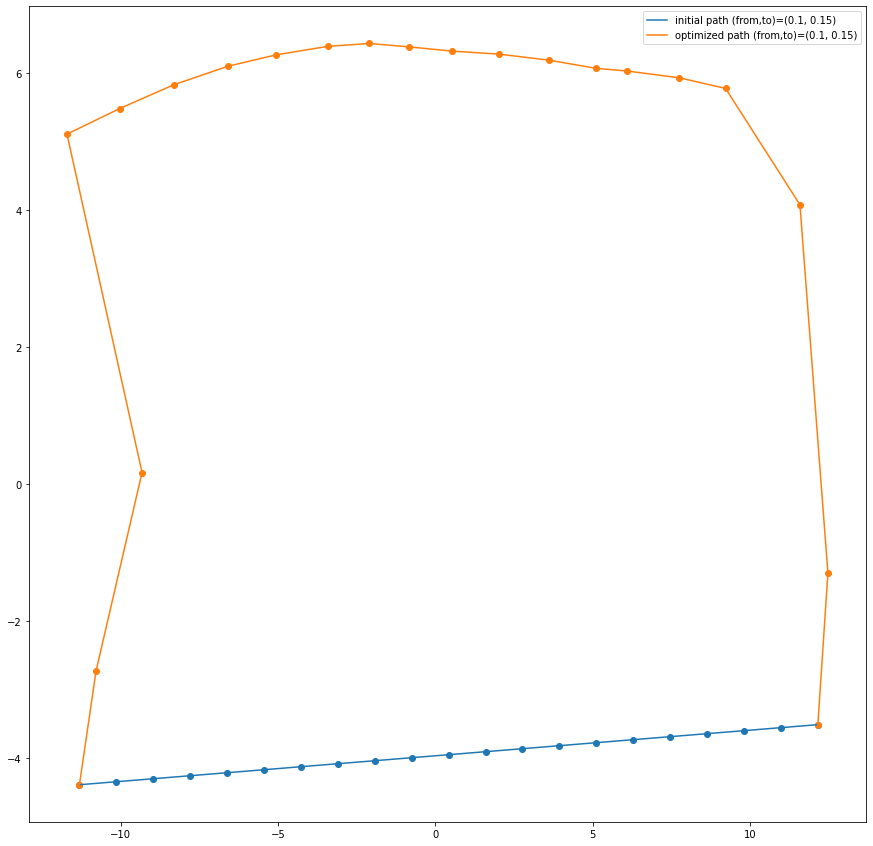

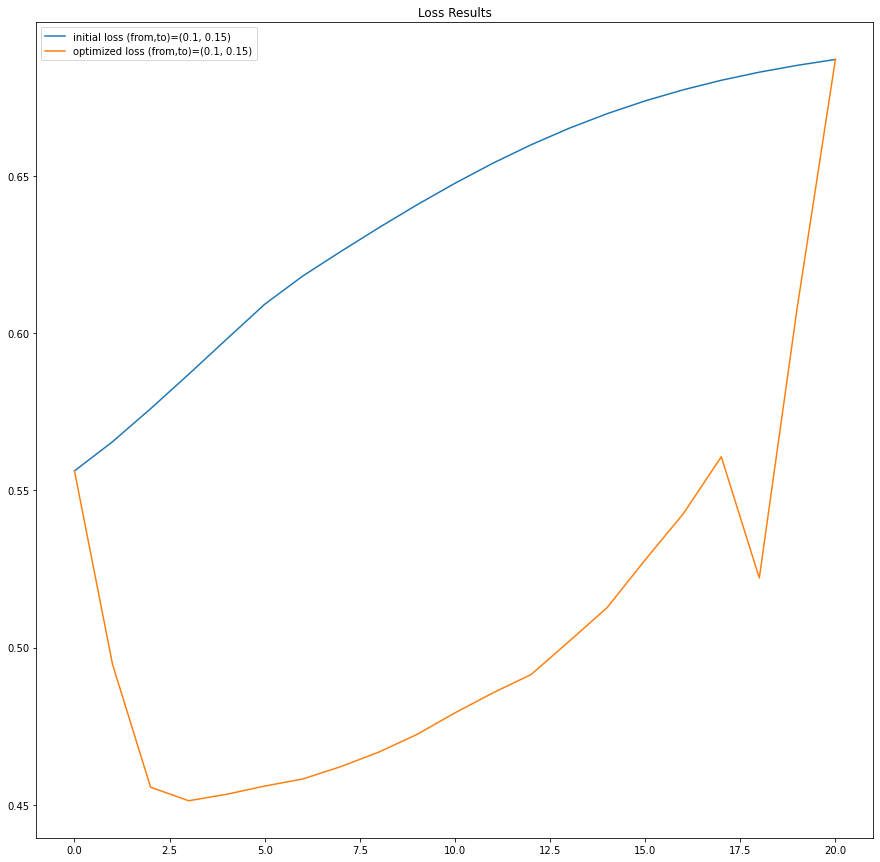

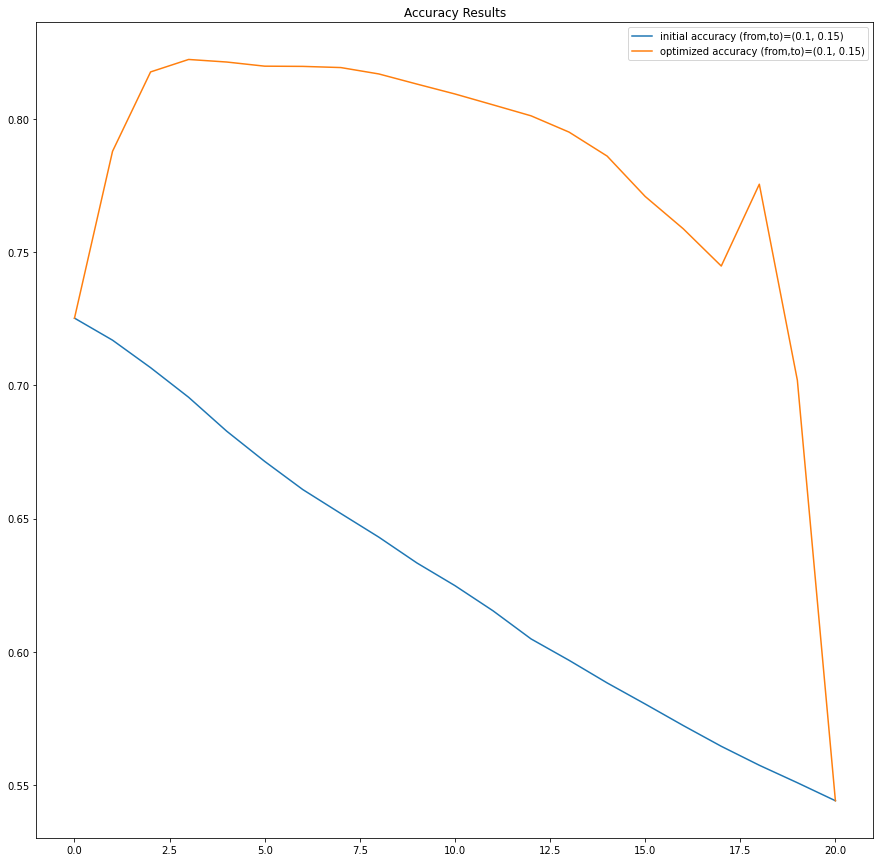

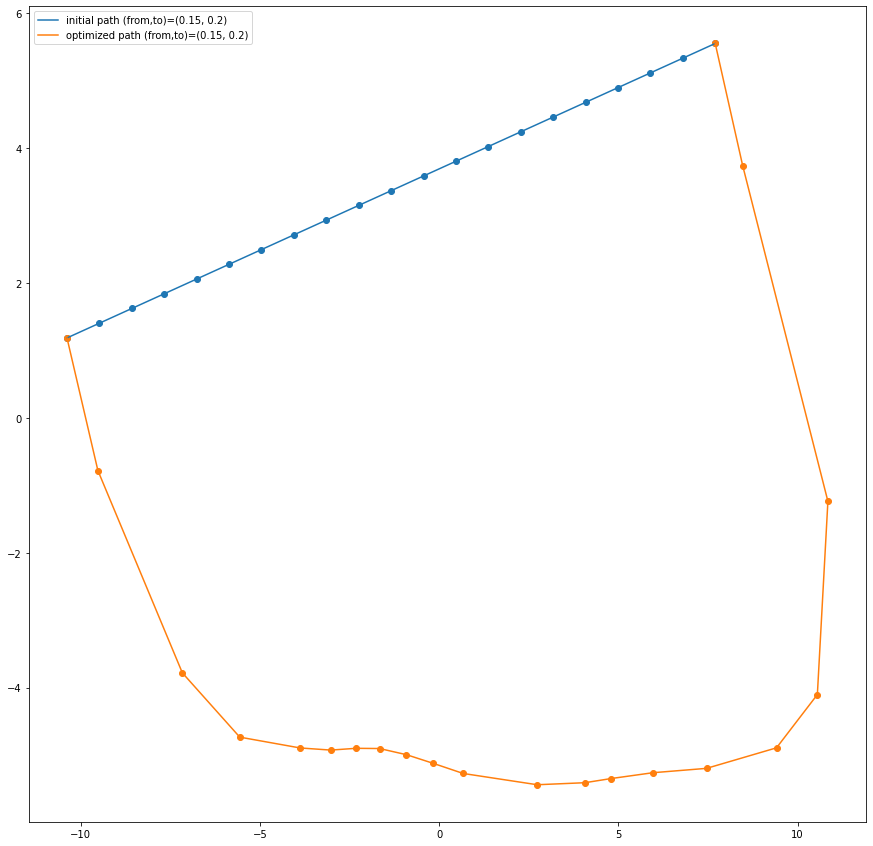

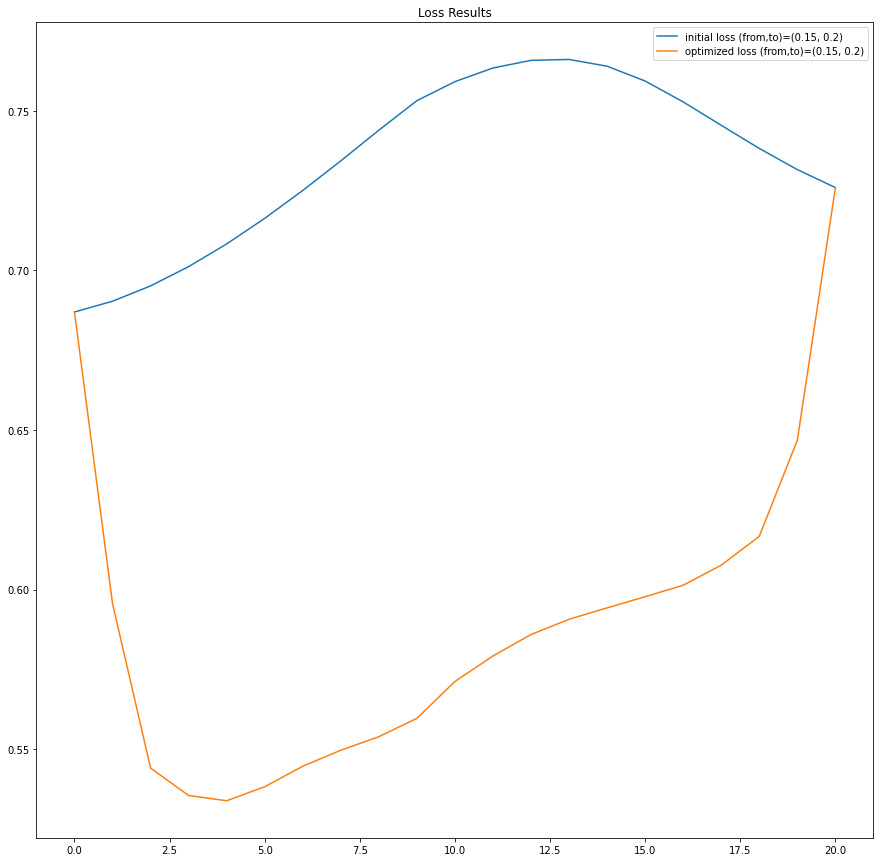

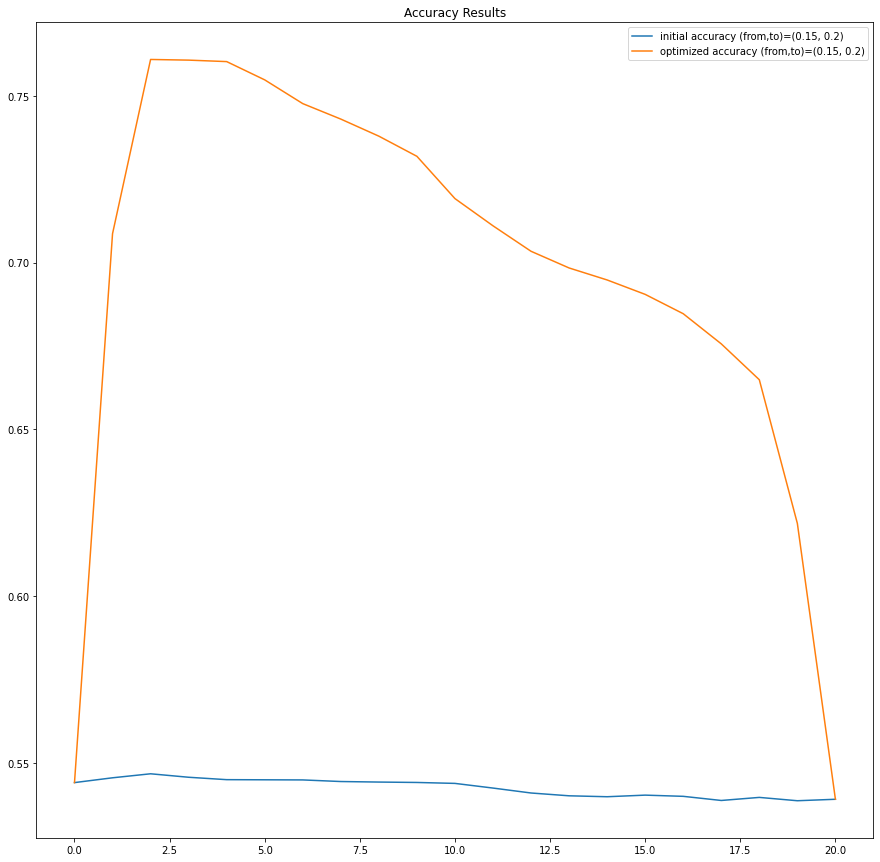

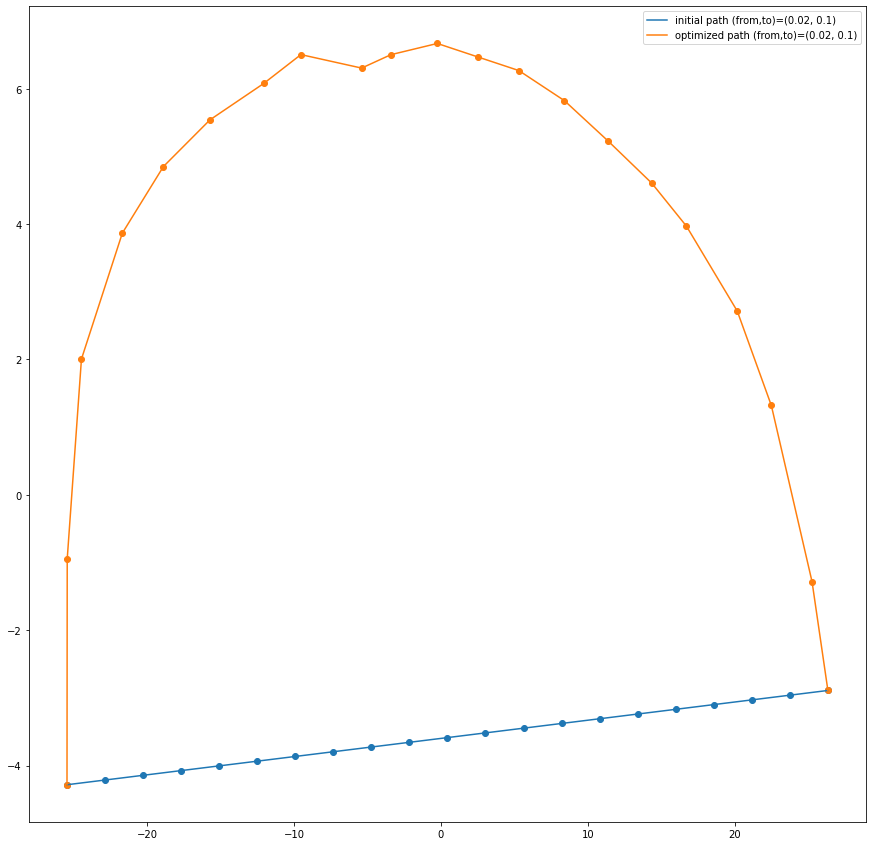

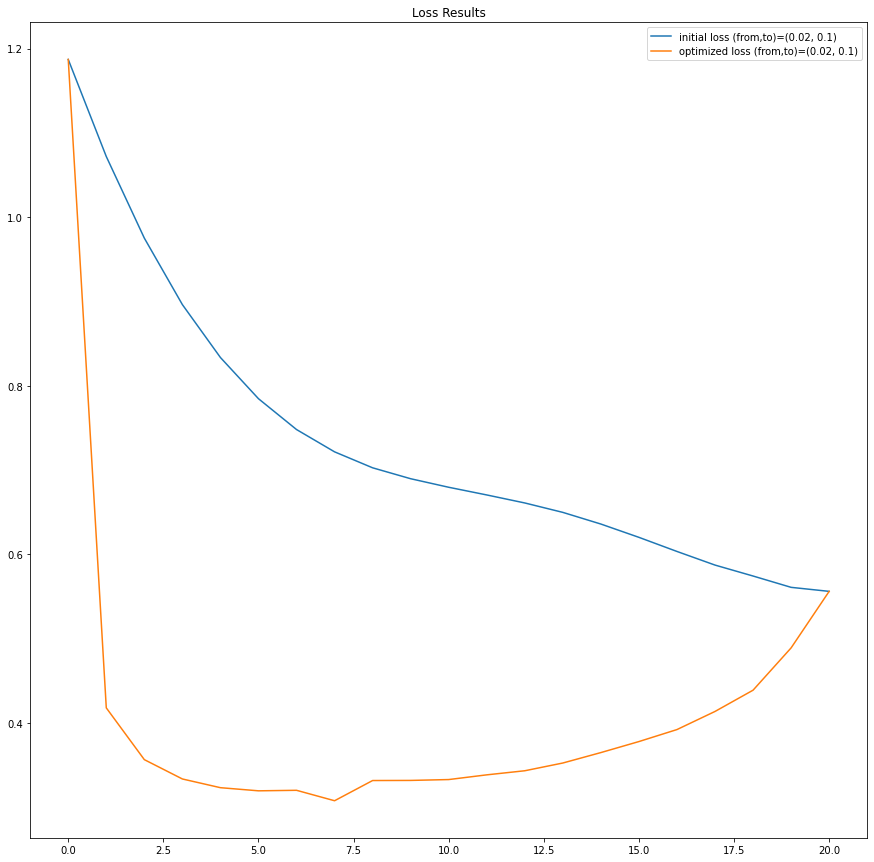

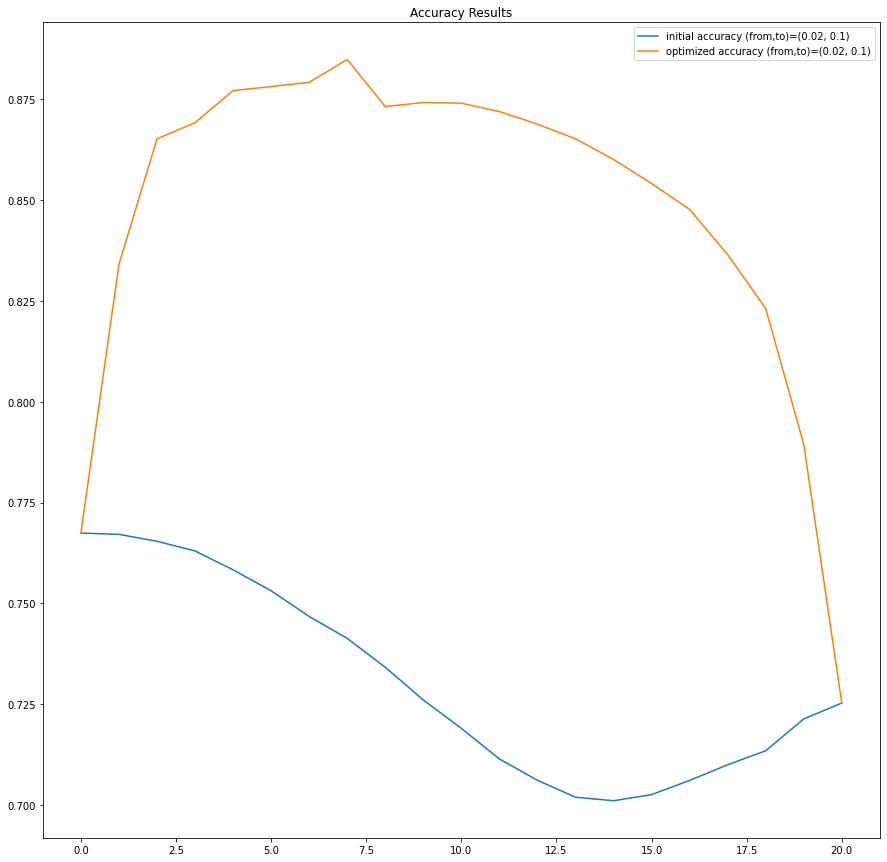

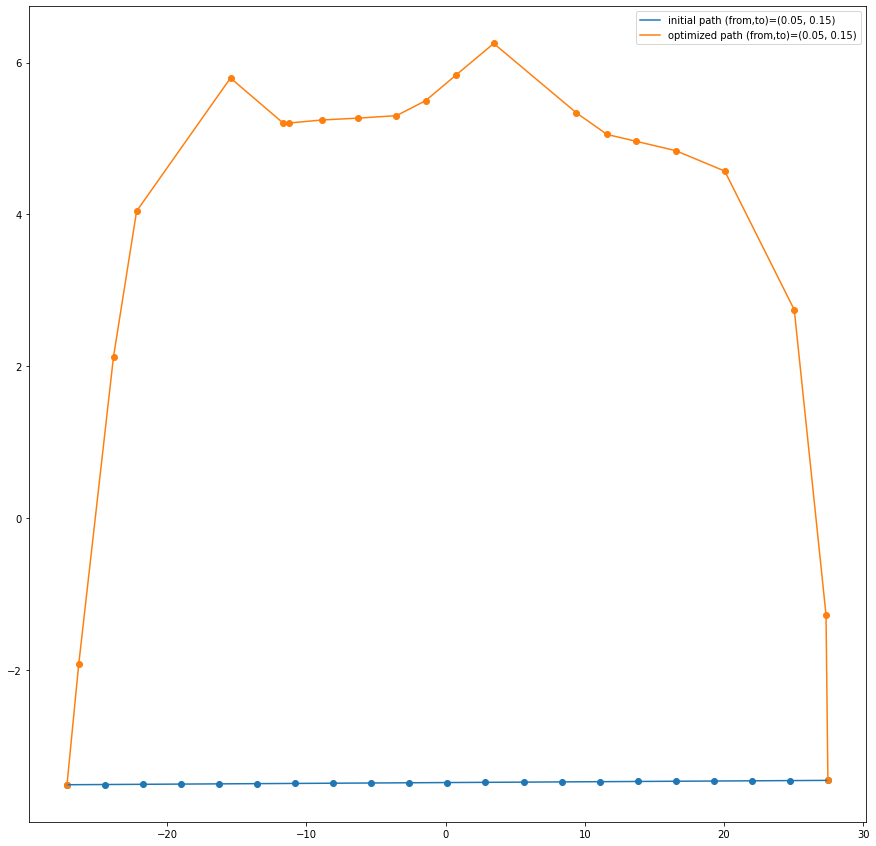

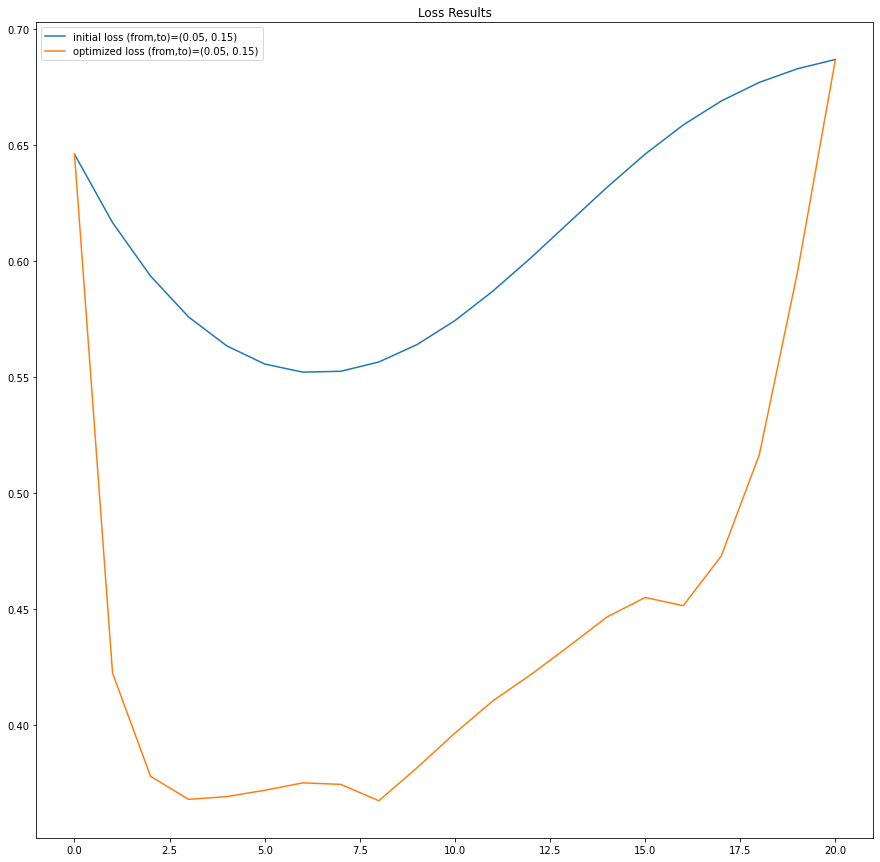

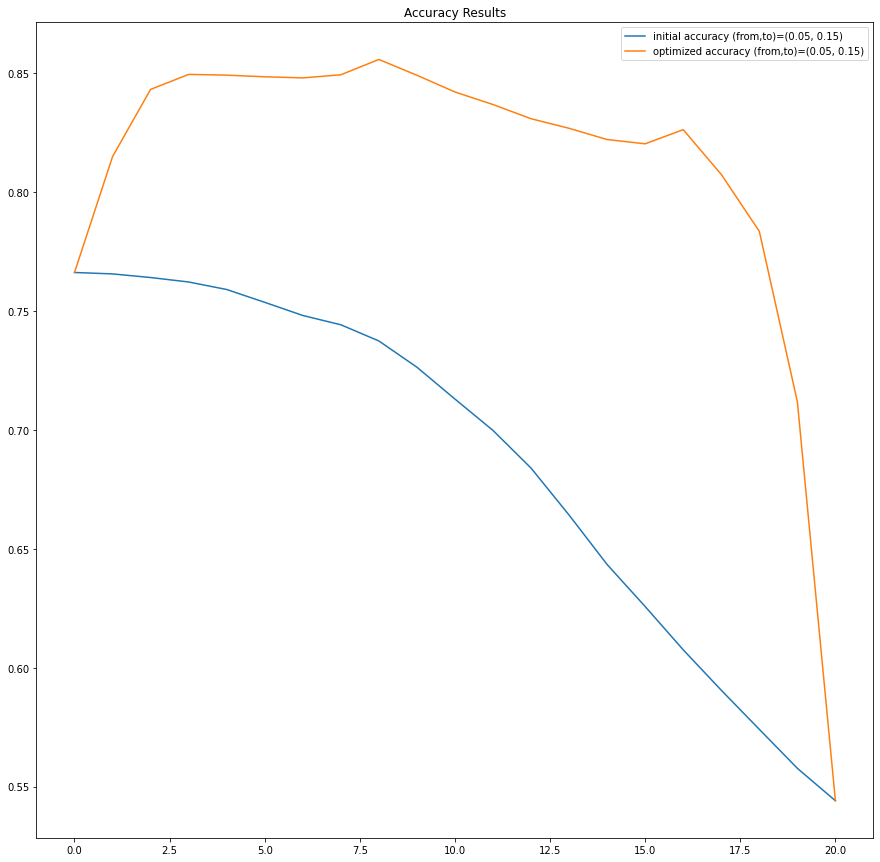

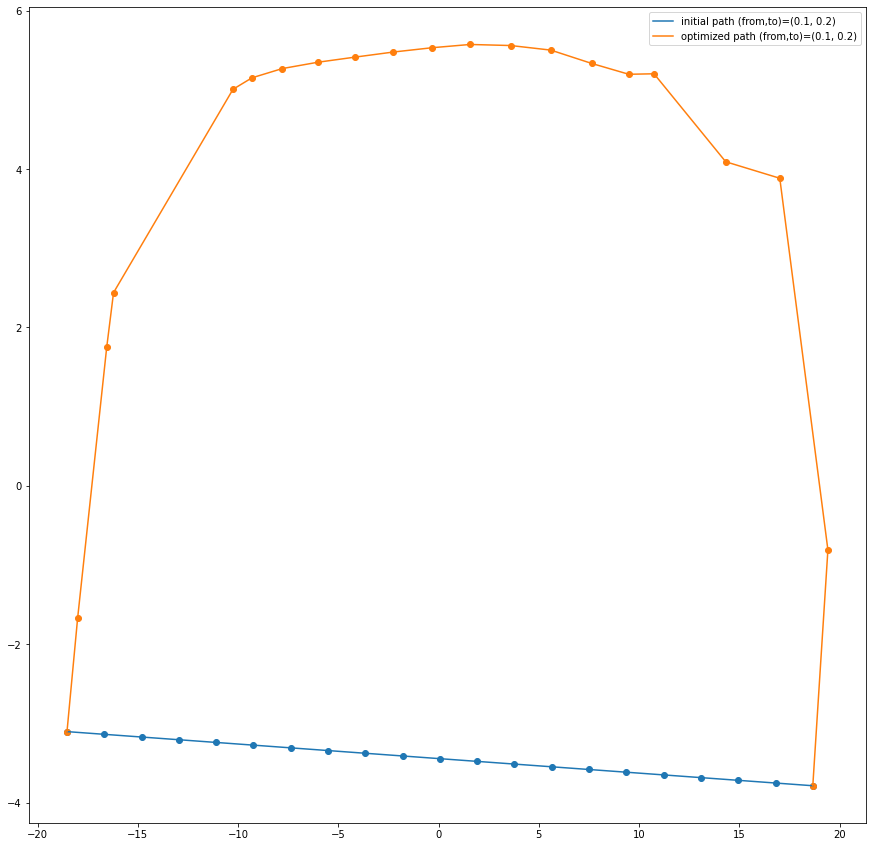

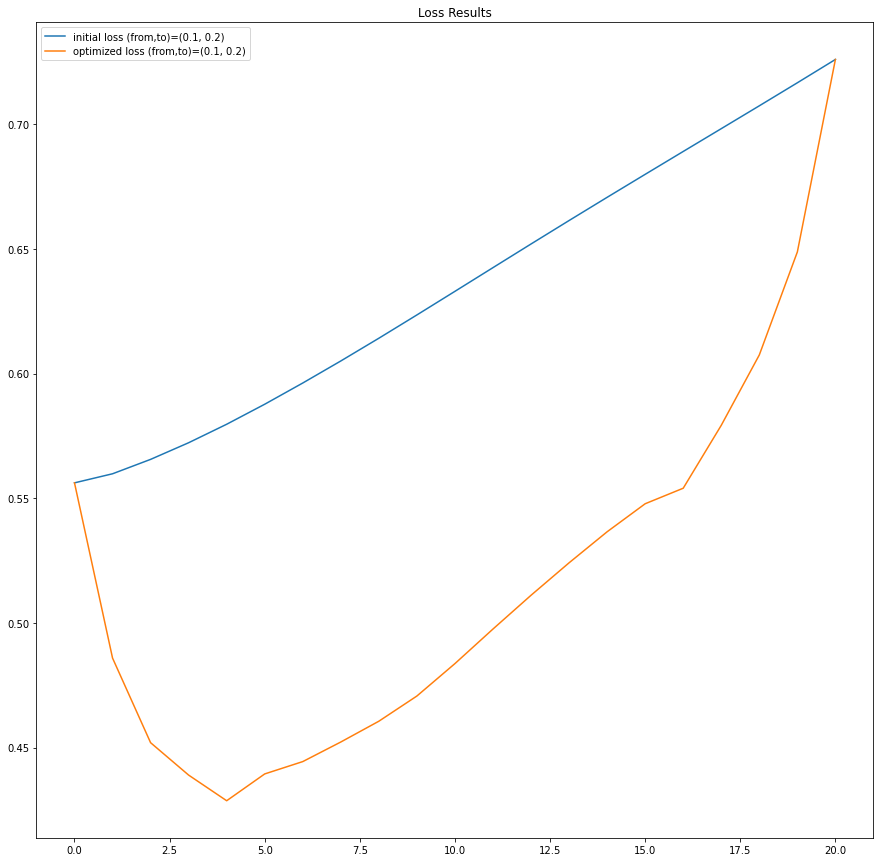

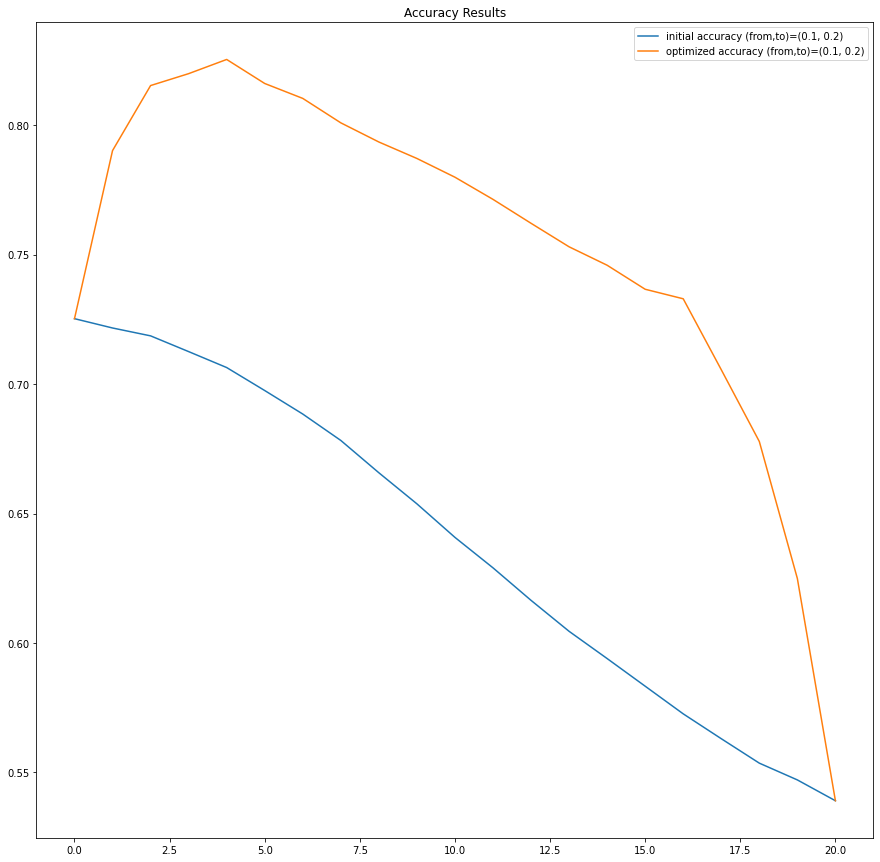

In [ ]:
runner.compareAllPaths()

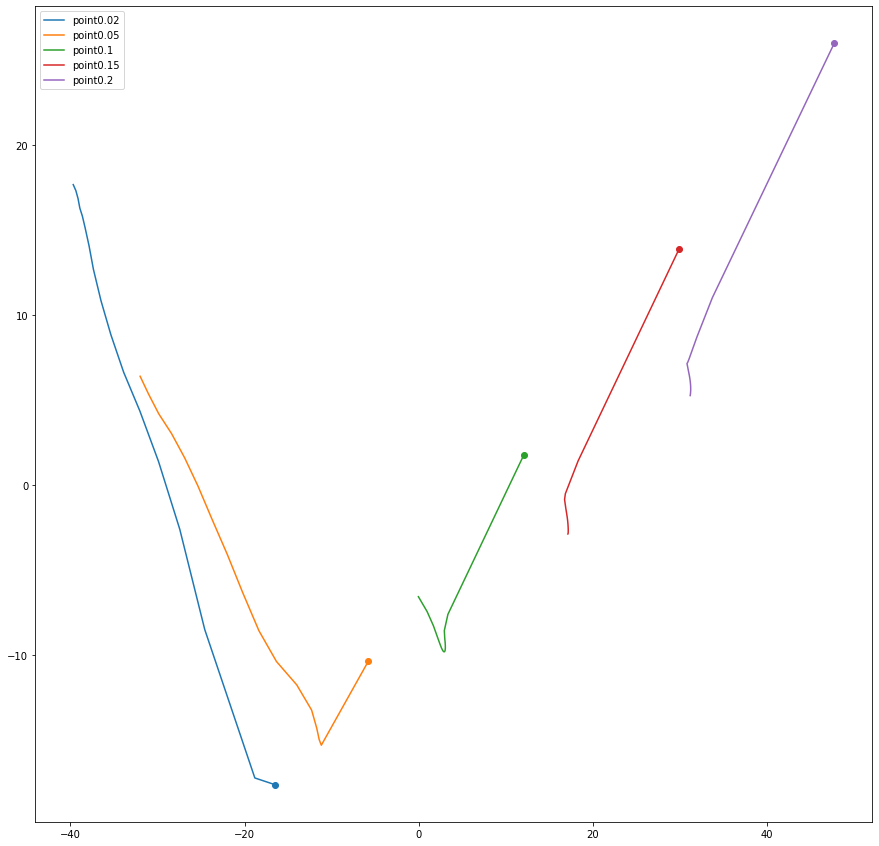

In [ ]:
#Her başlangıç noktasından başlanılan optimizasyon sürecinin çizdiği rota

rs=17
resultEpochs_arr=np.array(resultEpochs).reshape(rs*5,-1)
pca=PCA(n_components=2)
pca_weights=pca.fit_transform(resultEpochs_arr)
np.array(pca_weights).shape
plt.figure(figsize=(15, 15))
for i in range(len(resultEpochs_arr)//rs):
# Plotting both the curves simultaneously
  plt.plot(pca_weights[i*rs:(i+1)*rs,0], pca_weights[i*rs:(i+1)*rs,1], label='point'+str(startingPoints[i]))
  plt.scatter([pca_weights[i*rs,0]],[pca_weights[i*rs,1]])
# Naming the x-axis, y-axis and the whole graph
# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc='best')
# To load the display window
plt.show()

In [ ]:
def flatPath(path):
  new_p=[]
  for i in range(len(path)):
    p=[]
    for j in range(len(path[i])):
      p=p+path[i][j].flatten().tolist()
    new_p.append(np.array(p))
  return np.array(new_p)

In [ ]:
path1=runner.from_to_optimized[(-1,-0.35)]

In [ ]:
ensembles=runner.getEnsembles()